# Machine learning for Fraud Detection

### Yuri Catramby

Fraud detection is a critical issue in various industries, from financial services to e-commerce and healthcare. Fraud detection refers to the process of identifying and preventing fraudulent activities, such as fraudulent transactions, fake accounts, or identity theft.<br><br>


Fraud detection is important for businesses because fraud can have serious financial and reputational consequences. Costs associated with fraud include revenue loss, recovery costs, fines and penalties, as well as damage to brand reputation and loss of customer trust.<br><br>



The data science team has been called to help solve this problem by creating a system to classify transactions as fraudulent or not at the time of purchase, thus avoiding customer relationship issues and financial losses.<br><br>


IMPORTANT: Due to confidentiality, this data has been anonymized.

# Data Catalog

V Features - contains the result of a PCA transformation (because of the confidentiality)<br>

Time - contains the seconds elapsed between each transaction and the first transaction in the dataset<br>

 Amount - Transaction Amount<br>

 Class - 1: Fraud and 0: Not Fraud<br>

# 1.0 Loading Libraries

In [54]:
import time
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as m
import matplotlib.pyplot as plt
from functools import reduce
import random


from dtype_diet import report_on_dataframe
from dtype_diet import optimize_dtypes
from scipy.stats import normaltest
from scipy import stats


from sklearn.preprocessing import MinMaxScaler 
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from boruta import BorutaPy
from sklearn.utils import resample

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_recall_curve, auc, f1_score
from sklearn.ensemble import AdaBoostClassifier
from scipy.stats import randint
from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV

import pickle


from sklearn import metrics
from sklearn.metrics import homogeneity_completeness_v_measure
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score 


plt.style.use('fivethirtyeight')
%matplotlib inline

from IPython.display import Image

import warnings
warnings.filterwarnings("ignore")

# 2.0 Loading Dataset

In [3]:
df_raw = pd.read_csv('creditcard.csv')
df_raw.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# 3.0 Split into train and test data 

We are splitting the dataset at this point because that way the test data will simulate the production data, that is, never seen data.

In [4]:
X = df_raw.drop('Class', axis = 1)
y = df_raw[['Class']]

In [38]:
test_size = 0.3
seed = 42

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = seed)

In [41]:
print(f'X_train: {X_train.shape}')
print(f'y_train: {y_train.shape}')
print(f'X_test: {X_test.shape}')
print(f'y_test: {y_test.shape}')

X_train: (199364, 30)
y_train: (199364, 1)
X_test: (85443, 30)
y_test: (85443, 1)


In [40]:
df_train = pd.concat([X_test, y_test], axis=1)

# 4.0 Descriptive Analisys

In [8]:
df_desc = df_train.copy()

In [9]:
print("Number of rows: {}".format(df_desc.shape[0]))
print("Number of features: {}".format(df_desc.shape[1]))

Number of rows: 199364
Number of features: 31


In [10]:
# Data Type
df_desc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199364 entries, 2557 to 121958
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    199364 non-null  float64
 1   V1      199364 non-null  float64
 2   V2      199364 non-null  float64
 3   V3      199364 non-null  float64
 4   V4      199364 non-null  float64
 5   V5      199364 non-null  float64
 6   V6      199364 non-null  float64
 7   V7      199364 non-null  float64
 8   V8      199364 non-null  float64
 9   V9      199364 non-null  float64
 10  V10     199364 non-null  float64
 11  V11     199364 non-null  float64
 12  V12     199364 non-null  float64
 13  V13     199364 non-null  float64
 14  V14     199364 non-null  float64
 15  V15     199364 non-null  float64
 16  V16     199364 non-null  float64
 17  V17     199364 non-null  float64
 18  V18     199364 non-null  float64
 19  V19     199364 non-null  float64
 20  V20     199364 non-null  float64
 21  V21    

In [11]:
# Unique values by feature
df_desc.nunique()

Time      107202
V1        194190
V2        194190
V3        194190
V4        194190
V5        194190
V6        194190
V7        194190
V8        194190
V9        194190
V10       194190
V11       194190
V12       194190
V13       194190
V14       194190
V15       194190
V16       194190
V17       194190
V18       194190
V19       194190
V20       194190
V21       194190
V22       194190
V23       194190
V24       194190
V25       194190
V26       194190
V27       194190
V28       194190
Amount     27517
Class          2
dtype: int64

There is no null values

In [12]:
# Missing Values
df_desc.isnull().sum().sort_values(ascending = False)

Time      0
V16       0
Amount    0
V28       0
V27       0
V26       0
V25       0
V24       0
V23       0
V22       0
V21       0
V20       0
V19       0
V18       0
V17       0
V15       0
V1        0
V14       0
V13       0
V12       0
V11       0
V10       0
V9        0
V8        0
V7        0
V6        0
V5        0
V4        0
V3        0
V2        0
Class     0
dtype: int64

In [13]:
kurt = pd.DataFrame(df_desc.apply(lambda x: x.kurtosis())).T
skew = pd.DataFrame(df_desc.apply(lambda x: x.skew())).T
desc = pd.DataFrame(df_desc.describe())

df_stats = pd.concat([desc,  kurt, skew]).T.reset_index()
df_stats.columns = ['atributos','count', 'mean', 'std','min', '25%', '50%', '75%', 'max', 'kurtosis', 'skew']
df_stats

,atributos,count,mean,std,min,25%,50%,75%,max,kurtosis,skew
0,Time,199364.0,94748.021453,47474.287612,0.000000,54176.000000,84604.500000,139255.250000,172792.000000,-1.292916,-0.033636
1,V1,199364.0,-0.001491,1.960957,-56.407510,-0.920935,0.013616,1.314703,2.454930,34.559634,-3.357011
2,V2,199364.0,-0.002331,1.667882,-72.715728,-0.599013,0.066441,0.803312,22.057729,107.020966,-5.035310
3,V3,199364.0,0.002040,1.514420,-48.325589,-0.885992,0.182979,1.028217,4.187811,27.094271,-2.237770
4,V4,199364.0,-0.001072,1.416783,-5.683171,-0.849764,-0.021602,0.741059,16.875344,2.728478,0.686692
5,V5,199364.0,0.000499,1.393311,-113.743307,-0.689221,-0.056453,0.609969,34.801666,271.500191,-3.189437
6,V6,199364.0,-0.001898,1.337511,-26.160506,-0.768043,-0.274239,0.394597,73.301626,56.692293,2.063992
7,V7,199364.0,0.002623,1.248391,-43.557242,-0.551137,0.042759,0.570624,120.589494,525.320118,4.253673
8,V8,199364.0,-0.001166,1.188393,-73.216718,-0.207810,0.022222,0.326793,20.007208,232.003673,-8.623674
9,V9,199364.0,-0.000327,1.097011,-13.320155,-0.642266,-0.050710,0.597237,10.348407,3.455088,0.534814


**Amount**

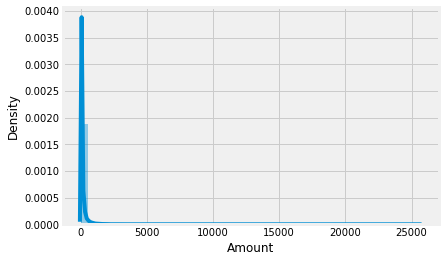

In [14]:
sns.distplot(df_desc['Amount'])
plt.show()

In [15]:
print(f"99% of transactions are under ${round(np.percentile(df_desc['Amount'], 99, axis = 0), 0)} and 75% under ${round(np.percentile(df_desc['Amount'], 75, axis = 0), 0)}")

99% of transactions are under $1019.0 and 75% under $77.0


**Class**

In [16]:
print(f"The dataset is highly unbalanced")
print(f"Class 0 (Not Fraud): {round(df_desc.groupby('Class').size()[0] / df_desc.shape[0] * 100, 2)}%")
print(f"Class 1 (Fraud): {round(df_desc.groupby('Class').size()[1] / df_desc.shape[0] * 100, 2)}%")

The dataset is highly unbalanced
Class 0 (Not Fraud): 99.82%
Class 1 (Fraud): 0.18%


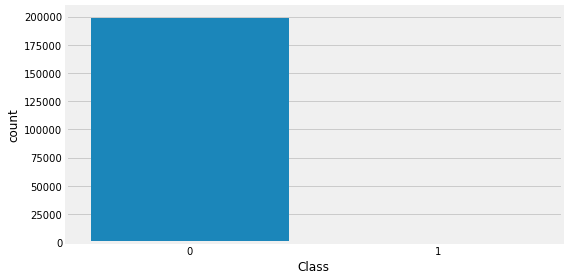

In [17]:
fig, axes = plt.subplots(1, 1, figsize = (8, 4))
_ = sns.countplot(data = df_desc, x = df_desc['Class'])
_ = plt.tight_layout()

In [18]:
df_desc.groupby('Class').size()

Class
0    199008
1       356
dtype: int64

**Time**

In the feature engineering stage we can treat this feature by creating some transformation like sin or cos. Because we'll be able to understand the variation of the cycle

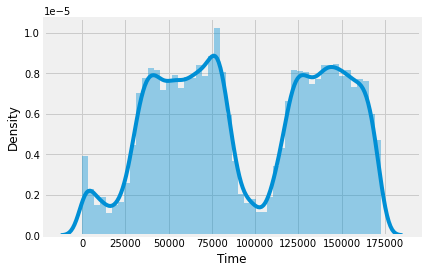

In [19]:
sns.distplot(df_desc['Time'])
plt.show()

# 5.0 EDA - Exploratory Data Analisys

In [20]:
df_eda = df_desc.copy()

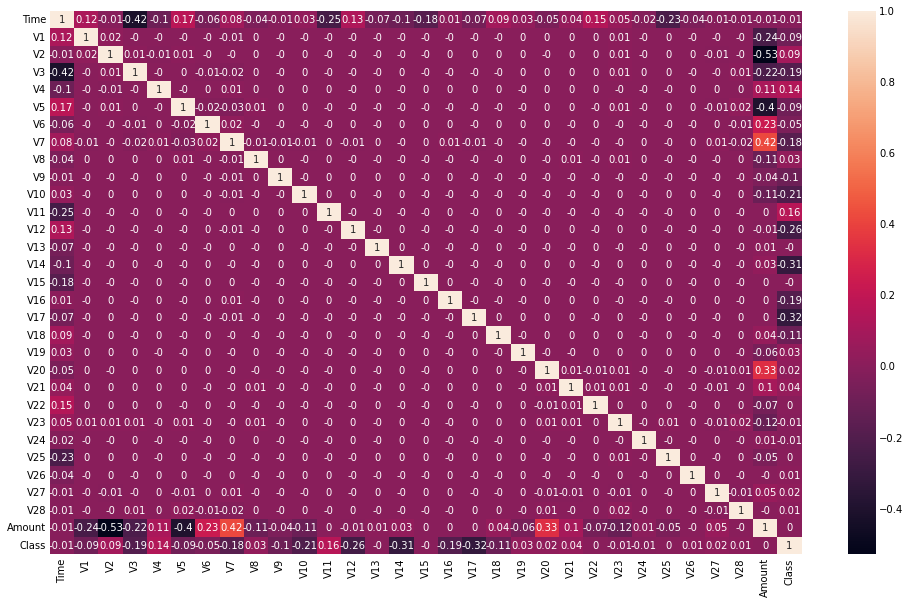

In [21]:
plt.figure(figsize=(15,10))

col_corr = df_eda.columns

corr = df_eda[col_corr].corr(method = 'pearson').round(2)

sns.heatmap(corr, annot=True)

plt.show()

Most features appear to be in a normal distribuition

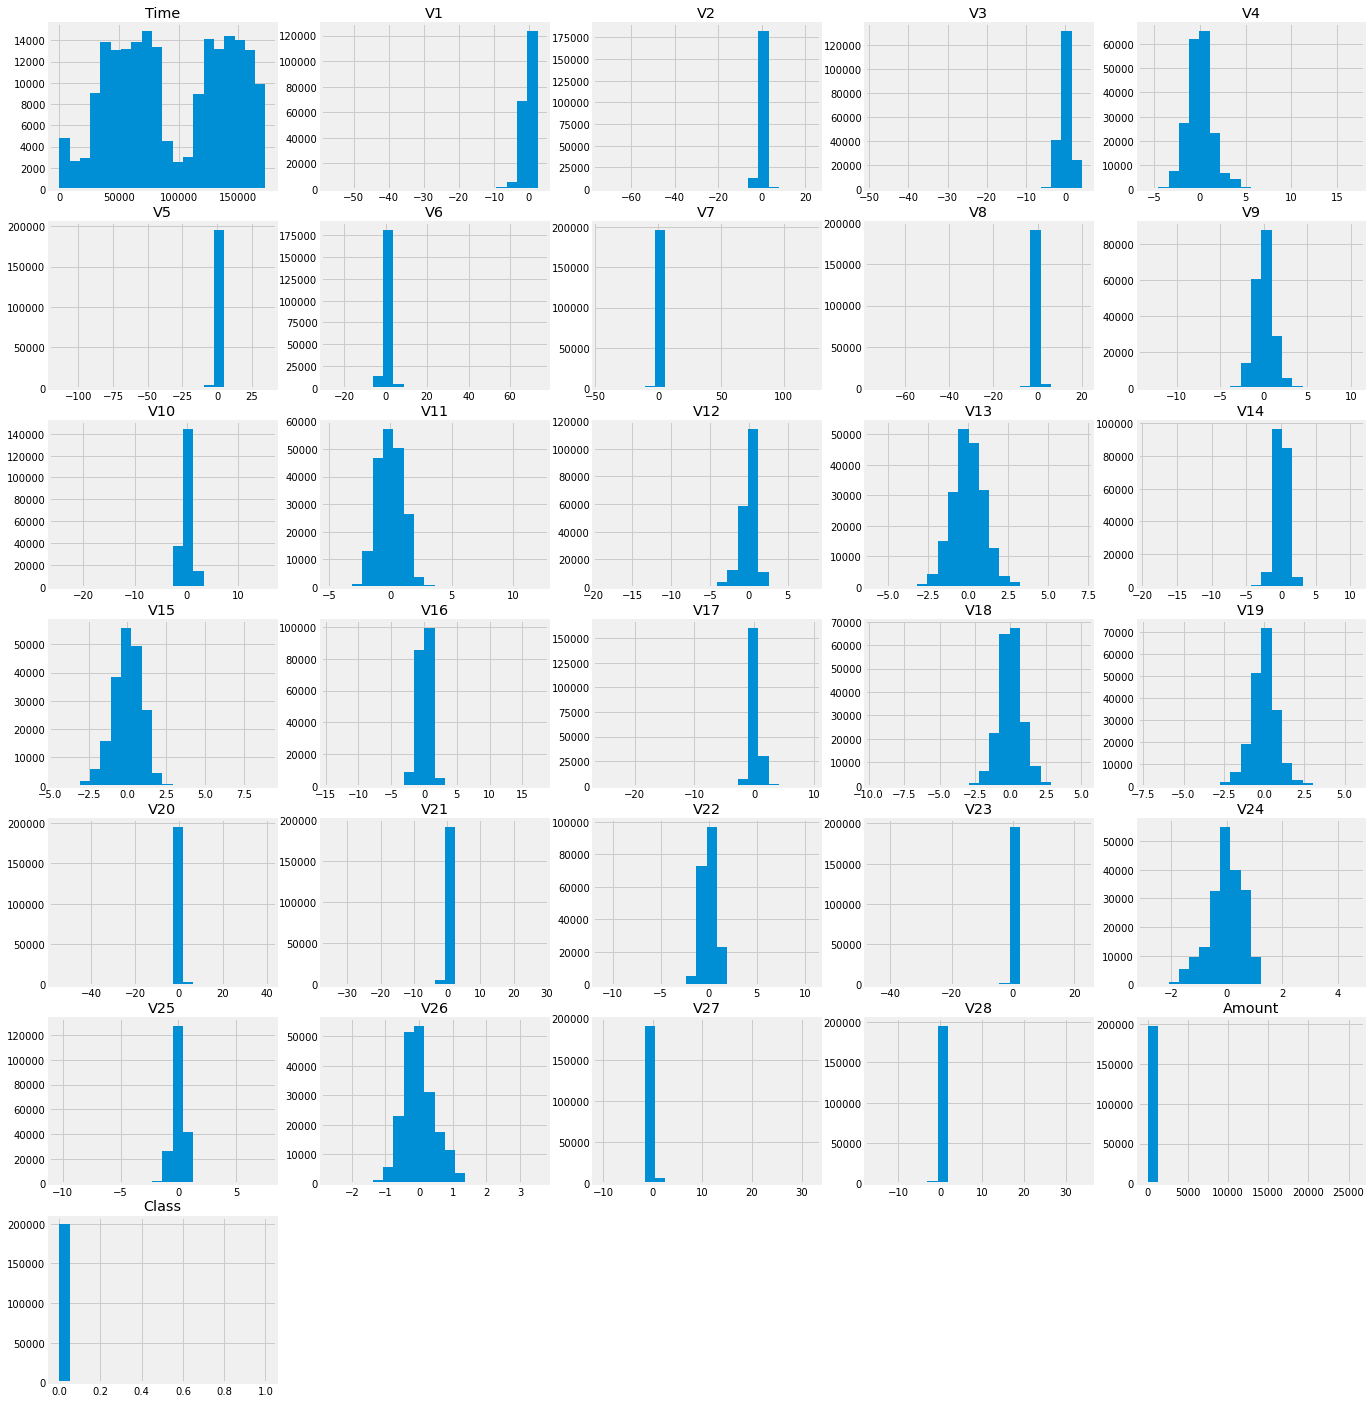

In [22]:
figure = plt.figure(figsize = (21, 25))

len_cols = len(col_corr)

for i in range(len_cols):
    figure.add_subplot(7, 5, i+1)
    plt.title(col_corr[i])
    df_eda[col_corr[i]].hist(bins = 20)
plt.show()

Amount

Fraudulent transactions had a lower average spending than good transactions

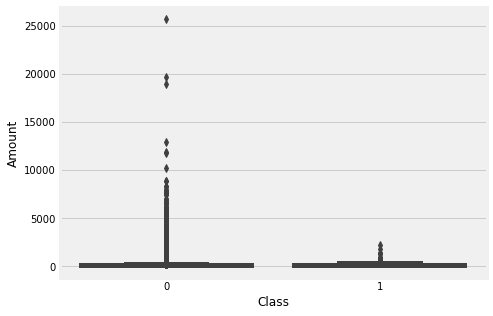

In [23]:
_ = plt.figure(figsize = (15, 5))

_ = plt.subplot(1, 2, 1)
_ = sns.boxplot(x = 'Class', y = 'Amount', data = df_eda[['Class', 'Amount']])

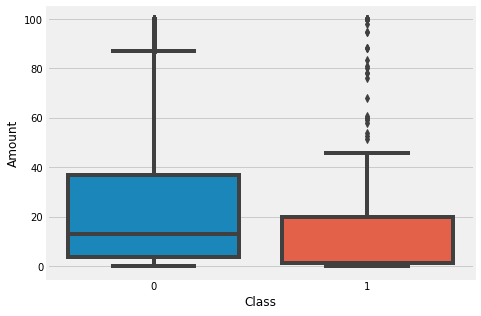

In [24]:
_ = plt.figure(figsize = (15, 5))

_ = plt.subplot(1, 2, 1)
_ = sns.boxplot(x = 'Class', y = 'Amount', data = df_eda[df_eda['Amount']<100][['Class', 'Amount']])

In [25]:
df_imb = df_eda.copy()

In [26]:
df_imb.groupby('Class').size()

Class
0    199008
1       356
dtype: int64

# 6.0 Test Models

In [27]:
seed = 42

## 6.1 Treatment For Imbalance

### 6.1.1 Class Weight

In [28]:
def cal_class_weight(df):
    y_imb = df['Class']

    class_freq = np.bincount(y)
    class_sqrt_freq = np.sqrt(class_freq)
    class_weight = class_sqrt_freq.sum() / (class_freq * class_sqrt_freq)
    class_weight_dict = dict(enumerate(class_weight))

    return class_weight_dict

### 6.1.2 Oversampling

In [29]:
def cal_resample(df):
    df_train_imbalanced = df.copy()
    df_train_over = resample(
        df[df['Class'] == 1],
        replace = True,
        n_samples = df.groupby('Class').size()[0] - df.groupby('Class').size()[1],
        random_state = seed
    )

    df_train_balanced = pd.concat([df_train_over, df_train_imbalanced])
    return df_train_balanced

## 6.2 Normalization or Standardization

In [34]:
cols_scaler = ['Time', 'Amount']

mms_scaler = MinMaxScaler()
std_scaler = StandardScaler()

list_scaler = [
    mms_scaler, 
    std_scaler
]

## 6.2 Models

In [32]:

model_lr = LogisticRegression(random_state = seed)
model_dt = DecisionTreeClassifier(random_state = seed)
model_rf = RandomForestClassifier(random_state = seed)
model_svm = SVC(random_state = seed)
model_nb = GaussianNB()
model_xgb = XGBClassifier(random_state = seed)
model_gb = GradientBoostingClassifier(random_state = seed)
model_ada = AdaBoostClassifier(random_state = seed)

list_models = [
    model_lr,
    model_dt,
    model_rf,
    model_svm,
    model_nb,
    model_xgb,
    model_gb,
    model_ada
]

## 6.3 Pipeline

In [ ]:
for scaler in list_scaler:
    for model in list_models:
        transformer = ColumnTransformer([('scaler', scaler, cols_scaler)])

        pipe = Pipeline(
            [('transformer', transformer),
             # ADD treatment for unbalanced data
             ('model', model)]
        )

        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)
        
        accuracy = accuracy_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        f1Score = f1_score(y_test, y_pred)
        rocAuc = roc_auc_score(y_test, y_pred)


In [55]:
# transformer = ColumnTransformer([('scaler', mms_scaler, cols_scaler)])

# pipe = Pipeline(
#     [('transformer', transformer),
#      ('model', model_ada)]
# )

# pipe.fit(X_train, y_train)
# y_pred = pipe.predict(X_test)

# print(f'Acuraccy: {accuracy_score(y_test, y_pred)}')
# print(f'Recall: {recall_score(y_test, y_pred)}')
# print(f'Precision: {precision_score(y_test, y_pred)}')
# print(f'F1-Score: {f1_score(y_test, y_pred)}')
# print(f'ROC/AUC: {roc_auc_score(y_test, y_pred)}')

Acuraccy: 0.9984082955888721
Recall: 0.0
Precision: 0.0
F1-Score: 0.0
ROC/AUC: 0.5


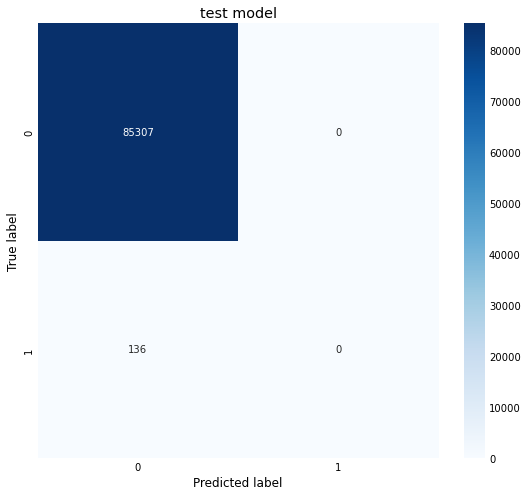

In [57]:
# plt.figure(figsize = (8, 8))

# cm = confusion_matrix(y_test, y_pred)

# sns.heatmap(cm, annot=True, cmap='Blues', fmt='.0f')
# plt.title('test model')
# plt.xlabel("Predicted label")
# plt.ylabel("True label")
    
# plt.show()